In [ ]:
# step6_Time_series_models1_full.py  (deterministic + Full_Timeline saved)
import os
import math
import time
import warnings
import random
import numpy as np
import pandas as pd
from pathlib import Path

# ARIMA (non-seasonal)
from statsmodels.tsa.arima.model import ARIMA

# ML (PyTorch) -- force CPU + determinism
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # disable GPU from the start

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

IN_EXPORT = Path("/content/Export_Master_Dataset_Clean.xlsx")
OUT_XLSX  = Path("Time_series_prediction.xlsx")

SECTORS   = ["Agriculture","Beverages","Dairy","Meat","Pharmaceuticals","Vegetables"]
FREQ      = "MS"

# Splits
TRAIN_END   = pd.Timestamp("2020-12-01")
VAL_START   = pd.Timestamp("2020-01-01")
VAL_END     = pd.Timestamp("2020-12-01")
TEST_START  = pd.Timestamp("2021-01-01")
TEST_END    = pd.Timestamp("2023-12-01")

# ARIMA grid (non-seasonal)
P_RANGE = range(0, 5)   # 0..4
D_RANGE = range(0, 3)   # 0..2
Q_RANGE = range(0, 5)   # 0..4

# Neural nets
DEVICE        = "cpu"   # <- force CPU for stable results
RAND_SEED     = 42
LOOKBACK      = 12
EPOCHS_LSTM   = 150
EPOCHS_TR     = 150
LR            = 1e-3
BATCH_SIZE    = 32


# utils
def set_seed(seed=RAND_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # make PyTorch deterministic on CPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(True)

def to_eurom_thousands(x):
    """convert thousand-euro columns to euro-million"""
    return pd.to_numeric(x, errors="coerce")/1000.0

def rmse(y, yhat):
    y, yhat = np.array(y, float), np.array(yhat, float)
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def mae(y, yhat):
    y, yhat = np.array(y, float), np.array(yhat, float)
    return float(np.mean(np.abs(y - yhat)))

def mape(y, yhat):
    y, yhat = np.array(y, float), np.array(yhat, float)
    mask = np.abs(y) > 1e-9
    if not mask.any():
        return np.nan
    return float(np.mean(np.abs((y[mask] - yhat[mask]) / y[mask])) * 100)

def build_supervised(series_1d, lookback=12):
    X, y = [], []
    for i in range(lookback, len(series_1d)):
        X.append(series_1d[i-lookback:i])
        y.append(series_1d[i])
    X = np.array(X)[:, :, None]  # (n, T, 1)
    y = np.array(y)
    return X, y

# NN models
class LSTMReg(nn.Module):
    def __init__(self, hidden=64, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden, num_layers=layers, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)          # (B,T,H)
        y = self.fc(out[:, -1, :])     # (B,1)
        return y.squeeze(-1)

class TinyTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, ff=128, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(1, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                           dim_feedforward=ff, dropout=dropout,
                                           batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.fc  = nn.Linear(d_model, 1)
    def forward(self, x):
        z = self.proj(x)               # (B,T,D)
        z = self.enc(z)                # (B,T,D)
        y = self.fc(z[:, -1, :])       # (B,1)
        return y.squeeze(-1)

def train_nn(model, Xtr, ytr, Xva, yva, epochs=150, lr=1e-3, batch=32):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=DEVICE)
    ytr_t = torch.tensor(ytr, dtype=torch.float32, device=DEVICE)
    Xva_t = torch.tensor(Xva, dtype=torch.float32, device=DEVICE)
    yva_t = torch.tensor(yva, dtype=torch.float32, device=DEVICE)

    best, best_state = math.inf, None
    n = Xtr.shape[0]
    for ep in range(1, epochs+1):
        model.train()
        # fixed mini-batch order for determinism
        idx = np.arange(n)
        for i in range(0, n, batch):
            b = idx[i:i+batch]
            xb, yb = Xtr_t[b], ytr_t[b]
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
        model.eval()
        with torch.no_grad():
            vpred = model(Xva_t)
            vloss = loss_fn(vpred, yva_t).item()
        if vloss < best:
            best = vloss
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        if ep % 25 == 0:
            print(f"[{model.__class__.__name__}] epoch {ep}/{epochs} - val_loss {vloss:.6f}")
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def recursive_forecast(model, scaler, hist_scaled, steps, lookback=12):
    seq = hist_scaled.copy()
    preds_scaled = []
    for _ in range(steps):
        x = seq[-lookback:].reshape(1, lookback, 1).astype(np.float32)
        xt = torch.tensor(x, dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            yhat_s = model(xt).detach().cpu().numpy().ravel()[0]
        preds_scaled.append(yhat_s)
        seq = np.append(seq, yhat_s)
    preds_scaled = np.array(preds_scaled).reshape(-1, 1)
    preds = scaler.inverse_transform(preds_scaled).ravel()
    return preds

# ARIMA tuning
def best_arima_by_val_rmse(train_sub, val_sub):
    """Fit ARIMA on train_sub, forecast val_sub, choose (p,d,q) with lowest RMSE."""
    best_cfg, best_rmse = None, math.inf
    # If validation is too short, fall back to a small pseudo-validation slice
    if len(val_sub) < 3 or len(train_sub) < 12:
        cut = max(6, min(12, len(train_sub)//4))
        if cut == 0:
            return (1,1,1), np.nan
        val_sub = train_sub[-cut:]
        train_sub = train_sub[:-cut]
    for p in P_RANGE:
        for d in D_RANGE:
            for q in Q_RANGE:
                try:
                    fit = ARIMA(train_sub, order=(p, d, q)).fit()
                    fc = fit.forecast(steps=len(val_sub))
                    r = rmse(val_sub.values, fc.values)
                    if r < best_rmse:
                        best_rmse = r
                        best_cfg = (p, d, q)
                except Exception:
                    continue
    return (best_cfg if best_cfg else (1,1,1)), best_rmse

# MAIN
def main():
    set_seed()

    # Read data
    df = pd.read_excel(IN_EXPORT)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.to_period("M").dt.to_timestamp()
    df = df.sort_values("Date")

    # Create *_EuroM on the fly if not present (from thousand-euro columns)
    for s in SECTORS:
        em = f"{s}_EuroM"
        if em not in df.columns and s in df.columns:
            df[em] = to_eurom_thousands(df[s])

    metrics_rows = []
    arima_param_rows = []
    forecasts_wide = {}

    for sector in SECTORS:
        ycol = f"{sector}_EuroM" if f"{sector}_EuroM" in df.columns else None
        if ycol is None:
            print(f"[WARN] Missing sector {sector}, skipping.")
            continue

        # build monthly series
        ts = df[["Date", ycol]].dropna().set_index("Date").asfreq(FREQ)[ycol]

        # splits
        train_full = ts.loc[:TRAIN_END]
        val        = ts.loc[VAL_START:VAL_END]
        train_sub  = ts.loc[:(VAL_START - pd.offsets.MonthBegin(1))]
        test       = ts.loc[TEST_START:TEST_END]

        if len(train_sub) < 24 or len(test) < 6:
            print(f"[WARN] Insufficient data for {sector}, skipping.")
            continue

        print(f"\n=== {sector} ===")
        print(f"Train_sub: {train_sub.index[0].date()} → {train_sub.index[-1].date()}")
        print(f"Val:       {val.index[0].date() if len(val)>0 else '—'} → {val.index[-1].date() if len(val)>0 else '—'}")
        print(f"TrainFull: {train_full.index[0].date()} → {train_full.index[-1].date()}")
        print(f"Test:      {test.index[0].date()} → {test.index[-1].date()}")

        # Initialize forecast wide frame for this sector
        fw = pd.DataFrame({"Date": test.index, "Sector": sector, "Actual": test.values})

        # ARIMA (tuned on validation RMSE, with fallback)
        t0 = time.perf_counter()
        (p, d, q), val_rmse_best = best_arima_by_val_rmse(train_sub, val)
        fit_val = ARIMA(train_sub, order=(p, d, q)).fit()
        val_fc  = fit_val.forecast(steps=len(val)) if len(val)>0 else pd.Series(index=val.index, dtype=float)
        # retrain on full training and forecast test
        fit_full = ARIMA(train_full, order=(p, d, q)).fit()
        test_fc  = fit_full.forecast(steps=len(test))
        t_arima = time.perf_counter() - t0

        metrics_rows.append({
            "Sector": sector, "Model": "ARIMA",
            "RMSE_val": (rmse(val.values, val_fc.values) if len(val)>0 else np.nan),
            "MAE_val":  (mae(val.values, val_fc.values)  if len(val)>0 else np.nan),
            "MAPE_val": (mape(val.values, val_fc.values) if len(val)>0 else np.nan),
            "RMSE_test": rmse(test.values, test_fc.values),
            "MAE_test":  mae(test.values, test_fc.values),
            "MAPE_test": mape(test.values, test_fc.values),
            "Runtime_sec": round(t_arima, 2),
            "Notes": f"order=({p},{d},{q})"
        })
        arima_param_rows.append({
            "Sector": sector, "p": p, "d": d, "q": q, "Validation_RMSE": val_rmse_best
        })
        fw["Pred_ARIMA"] = test_fc.values

        # LSTM
        t0 = time.perf_counter()
        scaler = StandardScaler()
        train_full_arr = train_full.values.reshape(-1, 1)
        scaler.fit(train_full_arr)
        train_scaled = scaler.transform(train_full_arr).ravel()

        # build train/val windows from within train_full (align val length; fallback if val short)
        if len(val) >= 3:
            X_tr, y_tr = build_supervised(train_scaled[:-len(val)], lookback=LOOKBACK)
            val_scaled = scaler.transform(val.values.reshape(-1,1)).ravel()
            X_va, y_va = build_supervised(np.concatenate([train_scaled[-LOOKBACK:], val_scaled]), lookback=LOOKBACK)
            if len(y_va) > len(val):
                y_va = y_va[-len(val):]
                X_va = X_va[-len(val):]
        else:
            cut = min(12, len(train_scaled)//4) or 6
            X_tr, y_tr = build_supervised(train_scaled[:-cut], lookback=LOOKBACK)
            X_va, y_va = build_supervised(train_scaled[-(cut+LOOKBACK):], lookback=LOOKBACK)

        lstm = LSTMReg(hidden=64, layers=2, dropout=0.2)
        lstm = train_nn(lstm, X_tr, y_tr, X_va, y_va, epochs=EPOCHS_LSTM, lr=LR, batch=BATCH_SIZE)

        hist_scaled_for_val  = train_scaled[:-len(val)] if len(val)>=1 else train_scaled[:-min(12,len(train_scaled)//4)]
        hist_scaled_for_test = train_scaled
        val_preds = (recursive_forecast(lstm, scaler, hist_scaled_for_val, steps=len(val),  lookback=LOOKBACK)
                     if len(val)>0 else np.array([]))
        test_preds = recursive_forecast(lstm, scaler, hist_scaled_for_test, steps=len(test), lookback=LOOKBACK)
        t_lstm = time.perf_counter() - t0

        metrics_rows.append({
            "Sector": sector, "Model": "LSTM",
            "RMSE_val": (rmse(val.values, val_preds) if len(val)>0 else np.nan),
            "MAE_val":  (mae(val.values,  val_preds) if len(val)>0 else np.nan),
            "MAPE_val": (mape(val.values, val_preds) if len(val)>0 else np.nan),
            "RMSE_test": rmse(test.values, test_preds),
            "MAE_test":  mae(test.values,  test_preds),
            "MAPE_test": mape(test.values, test_preds),
            "Runtime_sec": round(t_lstm, 2),
            "Notes": f"lookback={LOOKBACK}, hidden=64, layers=2, dropout=0.2"
        })
        fw["Pred_LSTM"] = test_preds

        #  Transformer
        t0 = time.perf_counter()
        transformer = TinyTransformer(d_model=64, nhead=4, num_layers=2, ff=128, dropout=0.1)
        transformer = train_nn(transformer, X_tr, y_tr, X_va, y_va, epochs=EPOCHS_TR, lr=LR, batch=BATCH_SIZE)

        val_preds_t = (recursive_forecast(transformer, scaler, hist_scaled_for_val, steps=len(val), lookback=LOOKBACK)
                       if len(val)>0 else np.array([]))
        test_preds_t = recursive_forecast(transformer, scaler, hist_scaled_for_test, steps=len(test), lookback=LOOKBACK)
        t_trans = time.perf_counter() - t0

        metrics_rows.append({
            "Sector": sector, "Model": "Transformer",
            "RMSE_val": (rmse(val.values, val_preds_t) if len(val)>0 else np.nan),
            "MAE_val":  (mae(val.values,  val_preds_t) if len(val)>0 else np.nan),
            "MAPE_val": (mape(val.values, val_preds_t) if len(val)>0 else np.nan),
            "RMSE_test": rmse(test.values, test_preds_t),
            "MAE_test":  mae(test.values,  test_preds_t),
            "MAPE_test": mape(test.values, test_preds_t),
            "Runtime_sec": round(t_trans, 2),
            "Notes": f"lookback={LOOKBACK}, d_model=64, nhead=4, layers=2"
        })
        fw["Pred_Transformer"] = test_preds_t

        forecasts_wide[sector] = fw

    # Build output sheets
    metrics_df = pd.DataFrame(metrics_rows)
    arima_df   = pd.DataFrame(arima_param_rows)

    # Best model flag per sector by RMSE_test
    if not metrics_df.empty:
        metrics_df["Best_Model_Flag"] = ""
        for sec, grp in metrics_df.groupby("Sector"):
            best_idx = grp["RMSE_test"].astype(float).idxmin()
            metrics_df.loc[best_idx, "Best_Model_Flag"] = "Yes"
            others = grp.index.difference([best_idx])
            metrics_df.loc[others, "Best_Model_Flag"] = "No"

    # Forecasts sheet: stack sector frames (test only)
    forecasts_df = (pd.concat(forecasts_wide.values(), ignore_index=True)
                    if forecasts_wide else
                    pd.DataFrame(columns=["Date","Sector","Actual","Pred_ARIMA","Pred_LSTM","Pred_Transformer"]))
    forecasts_df = forecasts_df.sort_values(["Sector","Date"])

    #Full timeline (2015–2023)
    full_rows = []
    for sector in SECTORS:
        ycol = f"{sector}_EuroM" if f"{sector}_EuroM" in df.columns else None
        if ycol is None:
            continue
        ts = df[["Date", ycol]].dropna().set_index("Date").asfreq(FREQ)[ycol]
        # train part
        train_part = ts.loc[:TRAIN_END]
        if len(train_part):
            full_rows.append(pd.DataFrame({
                "Date": train_part.index,
                "Sector": sector,
                "Actual": train_part.values,
                "Pred_ARIMA": np.nan,
                "Pred_LSTM": np.nan,
                "Pred_Transformer": np.nan,
                "Phase": "train"
            }))
        # test part (with forecasts if available)
        test_part = ts.loc[TEST_START:TEST_END]
        if len(test_part):
            if sector in forecasts_wide:
                fw = forecasts_wide[sector].copy()
                fw["Phase"] = "test"
                full_rows.append(fw[["Date","Sector","Actual","Pred_ARIMA","Pred_LSTM","Pred_Transformer","Phase"]])
            else:
                full_rows.append(pd.DataFrame({
                    "Date": test_part.index,
                    "Sector": sector,
                    "Actual": test_part.values,
                    "Pred_ARIMA": np.nan,
                    "Pred_LSTM": np.nan,
                    "Pred_Transformer": np.nan,
                    "Phase": "test"
                }))

    full_timeline_df = (pd.concat(full_rows, ignore_index=True)
                        if full_rows else
                        pd.DataFrame(columns=["Date","Sector","Actual","Pred_ARIMA","Pred_LSTM","Pred_Transformer","Phase"]))
    full_timeline_df = full_timeline_df.sort_values(["Sector","Date"])

    # Save
    with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as w:
        metrics_df.to_excel(w,   sheet_name="Metrics", index=False)
        forecasts_df.to_excel(w, sheet_name="Forecasts", index=False)
        arima_df.to_excel(w,     sheet_name="ARIMA_Params", index=False)
        full_timeline_df.to_excel(w, sheet_name="Full_Timeline", index=False)

    print(f"\n[OK] Wrote → {OUT_XLSX}")
    if not metrics_df.empty:
        print(metrics_df.groupby("Model")[['RMSE_test','MAE_test','MAPE_test','Runtime_sec']].mean().round(3))

if __name__ == "__main__":
    main()



=== Agriculture ===
Train_sub: 2015-01-01 → 2019-12-01
Val:       2020-01-01 → 2020-12-01
TrainFull: 2015-01-01 → 2020-12-01
Test:      2021-01-01 → 2023-12-01
[LSTMReg] epoch 25/150 - val_loss 0.828128
[LSTMReg] epoch 50/150 - val_loss 0.590965
[LSTMReg] epoch 75/150 - val_loss 0.877916
[LSTMReg] epoch 100/150 - val_loss 1.036246
[LSTMReg] epoch 125/150 - val_loss 1.102861
[LSTMReg] epoch 150/150 - val_loss 1.371241
[TinyTransformer] epoch 25/150 - val_loss 1.149625
[TinyTransformer] epoch 50/150 - val_loss 0.814147
[TinyTransformer] epoch 75/150 - val_loss 1.581387
[TinyTransformer] epoch 100/150 - val_loss 1.677545
[TinyTransformer] epoch 125/150 - val_loss 2.117401
[TinyTransformer] epoch 150/150 - val_loss 1.943169

=== Beverages ===
Train_sub: 2015-01-01 → 2019-12-01
Val:       2020-01-01 → 2020-12-01
TrainFull: 2015-01-01 → 2020-12-01
Test:      2021-01-01 → 2023-12-01
[LSTMReg] epoch 25/150 - val_loss 1.797780
[LSTMReg] epoch 50/150 - val_loss 1.812341
[LSTMReg] epoch 75/150 -

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Robust PPML (Poisson GLM) with sector-wise rescaling
# Input:  PPML_clean_Dataset.xlsx
# Output: PPML_Hybrid_prediction.xlsx

import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pathlib import Path
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning
from numpy.linalg import LinAlgError
# ML (PyTorch) -- force CPU + determinism
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # disable GPU from the start

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# 1) Input / Output
IN_FILE  = Path("/content/PPML_clean_Dataset.xlsx")
OUT_FILE = Path("PPML_Hybrid_prediction.xlsx")

#  2) Load dataset
df = pd.read_excel(IN_FILE)
df.columns = [c.strip() for c in df.columns]

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()
df["time_id"] = df["time_id"].astype(str)

def _safe_log(x):
    x = pd.to_numeric(x, errors="coerce")
    return np.log(np.clip(x.values.astype(float), a_min=1e-12, a_max=None))

df["ln_gdp_o"] = _safe_log(df["GDP_IE_real_eur_m"])
df["ln_gdp_d"] = _safe_log(df["GDP_UK_real_eur_m"])
df["ln_pop_o"] = _safe_log(df["pop_o"])
df["ln_pop_d"] = _safe_log(df["pop_d"])
df["ln_dist" ] = _safe_log(df["distw_harmonic"])

# Monthly FE
tfe = pd.get_dummies(df["time_id"], prefix="t", drop_first=True)

# RTA dummies
rta_cov_d = pd.get_dummies(df["rta_coverage"].fillna(-1).astype(int), prefix="rta_cov", drop_first=True)
rta_typ_d = pd.get_dummies(df["rta_type"].fillna(-1).astype(int),     prefix="rta_type", drop_first=True)
df = pd.concat([df, rta_cov_d, rta_typ_d], axis=1)

#3) Target sectors
sectors = [
    "Agriculture_EuroM","Beverages_EuroM","Dairy_EuroM",
    "Meat_EuroM","Pharmaceuticals_EuroM","Vegetables_EuroM"
]
sectors = [s for s in sectors if s in df.columns]

def tariff_cols_for(dep: str):
    base = dep.replace("_EuroM","")
    variants = [base, "Pharma"] if base.lower().startswith("pharma") else [base]
    cols = []
    for v in variants:
        for suf in ["WeightedAvg", "Imports_EuroM"]:
            c = f"{v}_{suf}"
            if c in df.columns:
                cols.append(c)
    return cols

bilat_bins = [c for c in ["contig","comlang_off","comcol","col45"] if c in df.columns]

# 4) Helpers
def drop_constant_or_near_constant(X, tol=1e-12):
    keep, dropped = [], []
    for c in X.columns:
        col = pd.to_numeric(X[c], errors="coerce")
        if col.isna().all():
            dropped.append((c, "all-NaN"))
        elif np.nanstd(col.values.astype(float)) <= tol:
            dropped.append((c, "near-constant"))
        else:
            keep.append(c)
    return X[keep], dropped

def try_fit_poisson(y, X):
    notes = []
    try:
        model = sm.GLM(y, X, family=sm.families.Poisson())
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", PerfectSeparationWarning)
            res = model.fit(cov_type="HC0")
            for ww in w:
                if issubclass(ww.category, PerfectSeparationWarning):
                    notes.append("PerfectSeparationWarning")
        return res, notes
    except (LinAlgError, ValueError) as e:
        notes.append(f"GLM failure: {type(e).__name__}")
        # retry with ridge
        model2 = sm.GLM(y, X, family=sm.families.Poisson())
        res2 = model2.fit_regularized(alpha=0.01, L1_wt=0.0, maxiter=500)
        class Wrap:
            def __init__(self, res, cols):
                self._params = np.asarray(res.params)
                self._cols = cols
            @property
            def params(self): return self._params
            @property
            def bse(self): return np.full_like(self._params, np.nan, dtype=float)
            @property
            def tvalues(self): return np.full_like(self._params, np.nan, dtype=float)
            @property
            def pvalues(self): return np.full_like(self._params, np.nan, dtype=float)
            def predict(self, Xmat): return np.exp(np.dot(Xmat, self._params))
            @property
            def _Xcols(self): return self._cols
        return Wrap(res2, X.columns.tolist()), notes

# 5) Fit per sector with rescaling
all_panels, all_coefs = [], []

for dep in sectors:
    base_name = dep.replace("_EuroM","")
    y = pd.to_numeric(df[dep], errors="coerce").astype(float)
    mask = ~y.isna()

    # rescale safeguard
    scale = np.nanmedian(y[mask])
    if scale <= 0 or np.isnan(scale):
        scale = 1.0
    y_scaled = y[mask] / scale

    # build X
    parts = [
        df.loc[mask, ["ln_gdp_o","ln_gdp_d","ln_pop_o","ln_pop_d","ln_dist"]],
        df.loc[mask, bilat_bins],
        df.loc[mask, df.columns.str.startswith("rta_cov_")],
        df.loc[mask, df.columns.str.startswith("rta_type_")],
        tfe.loc[mask]
    ]
    tarcols = tariff_cols_for(dep)
    if tarcols:
        parts.append(df.loc[mask, tarcols])

    X_df = pd.concat(parts, axis=1)
    X_df = sm.add_constant(X_df, has_constant="add").astype(float)

    X_fit_df, pre_dropped = drop_constant_or_near_constant(X_df)
    res, notes = try_fit_poisson(y_scaled.values, X_fit_df)
    res_cols = getattr(res, "_Xcols", X_fit_df.columns.tolist())

    X_for_pred = X_fit_df[res_cols].values
    y_pred_scaled = res.predict(X_for_pred)
    y_pred = y_pred_scaled * scale

    panel = pd.DataFrame({
        "Date": df.loc[mask, "Date"].values,
        "Sector": base_name,
        "Actual_Exports": y[mask].values,
        "PPML_Pred": y_pred,
    })
    panel["PPML_Residual"] = panel["Actual_Exports"] - panel["PPML_Pred"]
    all_panels.append(panel)

    coefs = pd.DataFrame({
        "sector": base_name,
        "variable": res_cols,
        "coef": getattr(res, "params", np.full(len(res_cols), np.nan)),
        "robust_se": getattr(res, "bse", np.full(len(res_cols), np.nan)),
        "z": getattr(res, "tvalues", np.full(len(res_cols), np.nan)),
        "pval": getattr(res, "pvalues", np.full(len(res_cols), np.nan)),
    })
    coefs["notes"] = "; ".join(notes)
    all_coefs.append(coefs)

ppml_panel = pd.concat(all_panels, ignore_index=True).sort_values(["Sector","Date"])
ppml_coefs = pd.concat(all_coefs, ignore_index=True)

# 6) Save
with pd.ExcelWriter(OUT_FILE, engine="openpyxl") as xw:
    ppml_panel.to_excel(xw, index=False, sheet_name="PPML_panel")
    ppml_coefs.to_excel(xw, index=False, sheet_name="PPML_coefficients")

print(f"[OK] Saved → {OUT_FILE}")
print("Sectors modeled:", sorted(ppml_panel["Sector"].unique().tolist()))
print("Panel rows:", len(ppml_panel))


[OK] Saved → PPML_Hybrid_prediction.xlsx
Sectors modeled: ['Agriculture', 'Beverages', 'Dairy', 'Meat', 'Pharmaceuticals', 'Vegetables']
Panel rows: 648


In [ ]:
# residual_forecasting_step8.py
import warnings, time, math, itertools, numpy as np, pandas as pd
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Sequential
# ML (PyTorch) -- force CPU + determinism
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # disable GPU from the start

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")
np.random.seed(7); tf.random.set_seed(7)

PPML_FILE = Path("/content/PPML_Hybrid_prediction.xlsx")   # sheet: PPML_panel
OUT_RES   = Path("Residual_Forecasts_prediction.xlsx")

TRAIN_END  = pd.Timestamp("2020-12-01")
VAL_START  = pd.Timestamp("2020-01-01")
VAL_END    = pd.Timestamp("2020-12-01")
TEST_START = pd.Timestamp("2021-01-01")

P_RANGE = range(0,3)  # p: 0..2
D_RANGE = range(0,2)  # d: 0..1
Q_RANGE = range(0,3)  # q: 0..2

LOOKBACK = 9
EPOCHS   = 120
BATCH    = 16
PATIENCE = 8
LSTM_UNITS = 32
DROPOUT    = 0.2
TFM_DMODEL = 48
TFM_HEADS  = 4

def rmse(y, yhat): return float(math.sqrt(mean_squared_error(y, yhat)))
def mae(y, yhat):  return float(mean_absolute_error(y, yhat))
def mape(y, yhat, eps=1e-6):
    y, yhat = np.asarray(y,float), np.asarray(yhat,float)
    denom = np.clip(np.abs(y), eps, None);
    return float(np.mean(np.abs((y - yhat) / denom))*100)

def to_supervised(arr, lookback):
    X, Y = [], []
    for i in range(len(arr)-lookback):
        X.append(arr[i:i+lookback]); Y.append(arr[i+lookback])
    return np.array(X, dtype="float32")[...,None], np.array(Y, dtype="float32")

def standardize(train, series):
    mu, sd = float(np.mean(train)), float(np.std(train)) or 1.0
    return (series - mu)/sd, mu, sd

def inv_standardize(x, mu, sd): return x*sd + mu

def best_arima_order(y_train, y_val):
    best = (None, np.inf)
    for p,d,q in itertools.product(P_RANGE, D_RANGE, Q_RANGE):
        if (p,d,q)==(0,0,0): continue
        try:
            m = ARIMA(y_train, order=(p,d,q)).fit(method_kwargs={"warn_convergence":False})
            f = m.forecast(steps=len(y_val))
            s = rmse(y_val, f)
            if s < best[1]: best = ((p,d,q), s)
        except Exception:
            pass
    return best[0] if best[0] else (1,0,1)

def build_lstm(input_len, units=32, dropout=0.2):
    m = Sequential([
        layers.Input(shape=(input_len,1)),
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

class SmallTransformer(tf.keras.Model):
    def __init__(self, d_model=48, nhead=4, dropout=0.2):
        super().__init__()
        self.proj = layers.Dense(d_model)
        self.mha  = layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model//nhead)
        self.ln1  = layers.LayerNormalization()
        self.ffn  = tf.keras.Sequential([
            layers.Dense(d_model*2, activation="relu"),
            layers.Dropout(dropout),
            layers.Dense(d_model)
        ])
        self.ln2  = layers.LayerNormalization()
        self.head = layers.Dense(1)
    def call(self, x, training=False):
        z = self.proj(x)
        attn = self.mha(z, z)
        z = self.ln1(z + attn)
        z2 = self.ffn(z, training=training)
        z = self.ln2(z + z2)
        z = tf.reduce_mean(z, axis=1)
        return self.head(z)

def train_keras(model, X_tr, y_tr, X_val, y_val, epochs=120, batch=16):
    es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch, verbose=0, callbacks=[es])
    return model

#load pane
panel = pd.read_excel(PPML_FILE, sheet_name="PPML_panel")
panel.columns = [c.strip() for c in panel.columns]
panel["Date"] = pd.to_datetime(panel["Date"], errors="coerce")
panel = panel.sort_values(["Sector","Date"]).dropna(subset=["PPML_Residual"])

sectors = panel["Sector"].dropna().unique().tolist()

res_metrics, res_best, res_preds = [], [], []

for sec in sectors:
    s = panel[panel["Sector"]==sec][["Date","Actual_Exports","PPML_Pred","PPML_Residual"]].copy()
    s = s.sort_values("Date").reset_index(drop=True)

    train_full = s[(s["Date"]<=TRAIN_END)]["PPML_Residual"].values.astype("float32")
    val_seg    = s[(s["Date"]>=VAL_START) & (s["Date"]<=VAL_END)]["PPML_Residual"].values.astype("float32")
    test_seg   = s[(s["Date"]>=TEST_START)]["PPML_Residual"].values.astype("float32")

    act_test   = s[(s["Date"]>=TEST_START)]["Actual_Exports"].values.astype("float32")
    ppm_test   = s[(s["Date"]>=TEST_START)]["PPML_Pred"].values.astype("float32")
    test_dates = s[(s["Date"]>=TEST_START)]["Date"].values

    if len(train_full) < (LOOKBACK+6) or len(test_seg)==0:
        continue

    # ARIMA
    t0=time.time()
    if len(val_seg)>0 and len(train_full)>len(val_seg):
        order = best_arima_order(train_full[:-len(val_seg)], val_seg)
    else:
        cut = max(6, min(12, len(train_full)//4))
        order = best_arima_order(train_full[:-cut], train_full[-cut:])
    try:
        ar = ARIMA(train_full, order=order).fit(method_kwargs={"warn_convergence":False})
        pred_ar = ar.forecast(steps=len(test_seg))
    except Exception:
        pred_ar = np.zeros(len(test_seg), dtype="float32")
    t_ar = time.time() - t0

    # LSTM
    y_tr_std, mu, sd = standardize(train_full, train_full)
    X_all, y_all = to_supervised(y_tr_std, LOOKBACK)
    if len(X_all) < 8:
        pred_lstm = np.zeros(len(test_seg), dtype="float32"); t_lstm = 0.0
    else:
        v = max(1, int(0.15*len(X_all)))
        X_tr, y_tr = X_all[:-v], y_all[:-v]
        X_val, y_val = X_all[-v:], y_all[-v:]
        lstm = build_lstm(LOOKBACK, units=LSTM_UNITS, dropout=DROPOUT)
        t1 = time.time()
        lstm = train_keras(lstm, X_tr, y_tr, X_val, y_val, epochs=EPOCHS, batch=BATCH)
        t_lstm = time.time() - t1
        # roll-forward
        hist = list(y_tr_std); preds=[]
        for _ in range(len(test_seg)):
            x = np.array(hist[-LOOKBACK:], dtype="float32").reshape(1,LOOKBACK,1)
            preds.append(float(lstm.predict(x, verbose=0)[0,0])); hist.append(preds[-1])
        pred_lstm = inv_standardize(np.array(preds), mu, sd)

    # Transformer
    if len(X_all) < 8:
        pred_tfm = np.zeros(len(test_seg), dtype="float32"); t_tfm = 0.0
    else:
        tfm = SmallTransformer(d_model=TFM_DMODEL, nhead=TFM_HEADS, dropout=DROPOUT)
        t2 = time.time()
        tfm = train_keras(tfm, X_tr, y_tr, X_val, y_val, epochs=EPOCHS, batch=BATCH)
        t_tfm = time.time() - t2
        hist = list(y_tr_std); preds=[]
        for _ in range(len(test_seg)):
            x = np.array(hist[-LOOKBACK:], dtype="float32").reshape(1,LOOKBACK,1)
            preds.append(float(tfm.predict(x, verbose=0)[0,0])); hist.append(preds[-1])
        pred_tfm = inv_standardize(np.array(preds), mu, sd)

    # metrics
    y_true = test_seg
    rows = []
    rows.append({"Sector":sec, "Model":"ARIMA",       "RMSE_test":rmse(y_true,pred_ar),  "MAE_test":mae(y_true,pred_ar),  "MAPE_test":mape(y_true,pred_ar),  "Runtime_sec":round(t_ar,2),  "Notes":f"order={order}"})
    rows.append({"Sector":sec, "Model":"LSTM",        "RMSE_test":rmse(y_true,pred_lstm),"MAE_test":mae(y_true,pred_lstm),"MAPE_test":mape(y_true,pred_lstm),"Runtime_sec":round(t_lstm,2),"Notes":f"lookback={LOOKBACK}, units={LSTM_UNITS}, dropout={DROPOUT}"})
    rows.append({"Sector":sec, "Model":"Transformer", "RMSE_test":rmse(y_true,pred_tfm), "MAE_test":mae(y_true,pred_tfm), "MAPE_test":mape(y_true,pred_tfm), "Runtime_sec":round(t_tfm,2), "Notes":f"lookback={LOOKBACK}, d_model={TFM_DMODEL}, heads={TFM_HEADS}, dropout={DROPOUT}"})
    res_metrics.extend(rows)

    # best
    best_row = min(rows, key=lambda r: r["RMSE_test"])
    res_best.append({"Sector":sec, **{k:best_row[k] for k in ["Model","RMSE_test","MAE_test","MAPE_test","Runtime_sec","Notes"]}})
    # predictions table
    res_preds.append(pd.DataFrame({
        "Date": test_dates, "Sector": sec,
        "Residual_Actual": y_true,
        "Resid_ARIMA": pred_ar, "Resid_LSTM": pred_lstm, "Resid_Transformer": pred_tfm
    }))

# save residual outputs
residual_metrics     = pd.DataFrame(res_metrics)
residual_predictions = pd.concat(res_preds, ignore_index=True) if res_preds else pd.DataFrame()
best_by_sector       = pd.DataFrame(res_best).rename(columns={"Model":"Best_Model"})

with pd.ExcelWriter(OUT_RES, engine="openpyxl") as xw:
    residual_metrics.to_excel(xw, index=False, sheet_name="Residual_metrics")
    residual_predictions.to_excel(xw, index=False, sheet_name="Residual_predictions")
    best_by_sector.to_excel(xw, index=False, sheet_name="Best_model_by_sector")


In [ ]:
# hybrid_construction_step9.py
import pandas as pd
import numpy as np
from pathlib import Path

PPML_FILE = Path("/content/PPML_Hybrid_prediction.xlsx")
RESID_FILE= Path("/content/Residual_Forecasts_prediction.xlsx")
OUT_FILE  = Path("Hybrid_Forecasts_prediction.xlsx")
TEST_START = pd.Timestamp("2021-01-01")
# ML (PyTorch) -- force CPU + determinism
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # disable GPU from the start

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
#load inputs
ppml = pd.read_excel(PPML_FILE, sheet_name="PPML_panel")
ppml.columns = [c.strip() for c in ppml.columns]
ppml["Date"] = pd.to_datetime(ppml["Date"], errors="coerce")

resid = pd.read_excel(RESID_FILE, sheet_name="Residual_predictions")
resid.columns = [c.strip() for c in resid.columns]
resid["Date"] = pd.to_datetime(resid["Date"], errors="coerce")

best = pd.read_excel(RESID_FILE, sheet_name="Best_model_by_sector")
best.columns = [c.strip() for c in best.columns]
best_map = best.set_index("Sector")["Best_Model"].to_dict()

#merge
m = ppml.merge(resid, on=["Date","Sector"], how="left")

def choose_res(row):
    bm = best_map.get(row["Sector"])
    if bm == "ARIMA":       return row.get("Resid_ARIMA", 0.0)
    if bm == "LSTM":        return row.get("Resid_LSTM", 0.0)
    if bm == "Transformer": return row.get("Resid_Transformer", 0.0)
    return 0.0

#  compute hybrid with runtime per sector
hy_rows = []
hy_panels = []

for sec, g in m.groupby("Sector", sort=False):
    g = g.sort_values("Date").copy()
    t0 = time.perf_counter()

    g["Resid_Best"]  = g.apply(choose_res, axis=1).fillna(0.0)
    g["Hybrid_Pred"] = g["PPML_Pred"] + g["Resid_Best"]

    t_hyb = time.perf_counter() - t0

    # metrics over test period
    test_g = g[g["Date"] >= TEST_START]
    a, p, h = test_g["Actual_Exports"].values, test_g["PPML_Pred"].values, test_g["Hybrid_Pred"].values

    def rmse(x,y): return float(np.sqrt(np.mean((np.asarray(x)-np.asarray(y))**2)))
    def mae(x,y):  return float(np.mean(np.abs(np.asarray(x)-np.asarray(y))))
    def mape(x,y):
        x,y = np.asarray(x,float), np.asarray(y,float)
        mask = x != 0
        return float(np.mean(np.abs((x[mask]-y[mask])/x[mask])*100)) if mask.any() else np.nan

    hy_rows.append({
        "Sector": sec,
        "RMSE_PPML":  rmse(a,p),
        "MAE_PPML":   mae(a,p),
        "MAPE_PPML":  mape(a,p),
        "RMSE_HYBRID": rmse(a,h),
        "MAE_HYBRID":  mae(a,h),
        "MAPE_HYBRID": mape(a,h),
        "HYB_Runtime_sec": round(t_hyb, 3)  # <-- runtime recorded
    })

    hy_panels.append(g[["Date","Sector","Actual_Exports","PPML_Pred","Resid_Best","Hybrid_Pred"]])

# save hybrid outputs
hy_panel  = pd.concat(hy_panels, ignore_index=True)
hy_metrics= pd.DataFrame(hy_rows).sort_values("Sector")
chosen    = best.rename(columns={"Model":"Best_Model"}) if "Model" in best.columns else best

with pd.ExcelWriter(OUT_FILE, engine="openpyxl") as xw:
    hy_panel.to_excel(xw, index=False, sheet_name="Hybrid_panel")
    hy_metrics.to_excel(xw, index=False, sheet_name="Hybrid_metrics")
    chosen.to_excel(xw, index=False, sheet_name="Chosen_models")

print(f"[OK] Saved → {OUT_FILE}")

[OK] Saved → Hybrid_Forecasts_prediction.xlsx


In [ ]:
# compare_hybrid_vs_timeseries_final.py
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

warnings.filterwarnings("ignore")

TS_FILE  = Path("/content/Time_series_prediction.xlsx")           # sheet: Metrics
HYB_FILE = Path("/content/Hybrid_Forecasts_prediction.xlsx")      # sheets: Hybrid_metrics + Chosen_models
OUT_FILE = Path("Hybrid_vs_TimeSeries_prediction.xlsx")

def norm_sector(s):
    return str(s).strip().title().replace("Pharma","Pharmaceuticals")

# 1) Load Time-Series metrics
ts = pd.read_excel(TS_FILE, sheet_name="Metrics")
ts.columns = [c.strip() for c in ts.columns]

# Header normalization for TS
ts.rename(columns={
    "sector":"Sector","model":"Model",
    "rmse_test":"RMSE_test","mae_test":"MAE_test","mape_test":"MAPE_test",
    "runtime_sec":"Runtime_sec"
}, inplace=True)

req_ts = {"Sector","Model","RMSE_test","MAE_test","MAPE_test"}
missing_ts = req_ts - set(ts.columns)
if missing_ts:
    raise ValueError(f"[Time-series] Missing required columns: {missing_ts}")

if "Runtime_sec" not in ts.columns:
    ts["Runtime_sec"] = np.nan

ts["Sector"] = ts["Sector"].map(norm_sector)

# Robust best-by-sector (avoid idxmin quirks)
ts_best = (
    ts.sort_values(["Sector","RMSE_test"], ascending=[True, True])
      .groupby("Sector", as_index=False)
      .head(1)
      .loc[:, ["Sector","Model","RMSE_test","MAE_test","MAPE_test","Runtime_sec"]]
      .rename(columns={
          "Model":"TS_Best_Model",
          "RMSE_test":"TS_RMSE",
          "MAE_test":"TS_MAE",
          "MAPE_test":"TS_MAPE",
          "Runtime_sec":"TS_Runtime_sec"
      })
      .reset_index(drop=True)
)

# 2) Load Hybrid metrics
# Try multiple sheet names for compatibility
try:
    hy = pd.read_excel(HYB_FILE, sheet_name="Hybrid_metrics")
except Exception:
    hy = pd.read_excel(HYB_FILE, sheet_name="Hybrid_Metrics")

hy.columns = [c.strip() for c in hy.columns]
# Normalize variants
hy.rename(columns={
    "sector":"Sector",
    "rmse_hybrid":"RMSE_HYBRID", "rmse_hyb":"RMSE_HYBRID",
    "mae_hybrid":"MAE_HYBRID",   "mae_hyb":"MAE_HYBRID",
    "mape_hybrid":"MAPE_HYBRID", "mape_hyb":"MAPE_HYBRID",
    "hyb_runtime_sec":"HYB_Runtime_sec"
}, inplace=True)

req_hy = {"Sector","RMSE_HYBRID","MAE_HYBRID","MAPE_HYBRID"}
missing_hy = req_hy - set(hy.columns)
if missing_hy:
    raise ValueError(f"[Hybrid] Missing required columns in Hybrid_metrics: {missing_hy}")

if "HYB_Runtime_sec" not in hy.columns:
    hy["HYB_Runtime_sec"] = np.nan

hy["Sector"] = hy["Sector"].map(norm_sector)
hy_tidy = hy[["Sector","RMSE_HYBRID","MAE_HYBRID","MAPE_HYBRID","HYB_Runtime_sec"]]

# 3) Load Hybrid chosen models (HYB_Best_Model)
hyb_best_sheet = None
for cand in ["Chosen_models","Best_model_by_sector","Best_models","Chosen_Models"]:
    try:
        hyb_best_sheet = pd.read_excel(HYB_FILE, sheet_name=cand)
        break
    except Exception:
        continue

HYB_best = None
if hyb_best_sheet is not None:
    s = hyb_best_sheet.copy()
    s.columns = [c.strip() for c in s.columns]
    # Normalize
    s.rename(columns={"sector":"Sector","best_model":"Best_Model"}, inplace=True)
    if "Sector" in s.columns and "Best_Model" in s.columns:
        s["Sector"] = s["Sector"].map(norm_sector)
        HYB_best = s[["Sector","Best_Model"]].rename(columns={"Best_Model":"HYB_Best_Model"})

# 4) Merge & decide winner
cmp = ts_best.merge(hy_tidy, on="Sector", how="outer")
if HYB_best is not None:
    cmp = cmp.merge(HYB_best, on="Sector", how="left")
else:
    cmp["HYB_Best_Model"] = np.nan  # not available in the source file

# Deltas (positive => Hybrid better)
cmp["Delta_RMSE"] = cmp["TS_RMSE"] - cmp["RMSE_HYBRID"]
cmp["Delta_MAE"]  = cmp["TS_MAE"]  - cmp["MAE_HYBRID"]
cmp["Delta_MAPE"] = cmp["TS_MAPE"] - cmp["MAPE_HYBRID"]

def choose_winner(row):
    wins = int(row["Delta_RMSE"]>0) + int(row["Delta_MAE"]>0) + int(row["Delta_MAPE"]>0)
    if wins >= 2:
        return "Hybrid"
    elif wins <= 1:
        return "Time-Series"
    # tie-breaker by runtime if both present
    ts_rt  = row.get("TS_Runtime_sec", np.inf)
    hy_rt  = row.get("HYB_Runtime_sec", np.inf)
    return "Hybrid" if hy_rt < ts_rt else "Time-Series"

cmp["Winner"] = cmp.apply(choose_winner, axis=1)

def pct_improve(ts_val, hyb_val):
    if pd.isna(ts_val) or pd.isna(hyb_val) or ts_val == 0:
        return np.nan
    return 100.0 * (float(ts_val) - float(hyb_val)) / float(ts_val)

cmp["RMSE_improve_%"] = cmp.apply(lambda r: pct_improve(r["TS_RMSE"], r["RMSE_HYBRID"]), axis=1)
cmp["MAE_improve_%"]  = cmp.apply(lambda r: pct_improve(r["TS_MAE"],  r["MAE_HYBRID"]), axis=1)
cmp["MAPE_improve_%"] = cmp.apply(lambda r: pct_improve(r["TS_MAPE"], r["MAPE_HYBRID"]), axis=1)

# Order columns nicely
cmp = cmp[[
    "Sector",
    "TS_Best_Model","TS_RMSE","TS_MAE","TS_MAPE","TS_Runtime_sec",
    "HYB_Best_Model","RMSE_HYBRID","MAE_HYBRID","MAPE_HYBRID","HYB_Runtime_sec",
    "Delta_RMSE","Delta_MAE","Delta_MAPE",
    "RMSE_improve_%","MAE_improve_%","MAPE_improve_%",
    "Winner"
]].sort_values("Sector").reset_index(drop=True)

# 5) Save
with pd.ExcelWriter(OUT_FILE, engine="openpyxl") as xw:
    cmp.to_excel(xw, index=False, sheet_name="Comparison")
    ts_best.to_excel(xw, index=False, sheet_name="Best_TS_Rows")
    hy_tidy.to_excel(xw, index=False, sheet_name="Hybrid_Metrics")

print(f"[OK] Saved → {OUT_FILE}")
print("\nWinner per sector:")
print(cmp[["Sector","Winner","RMSE_improve_%"]].to_string(index=False))


[OK] Saved → Hybrid_vs_TimeSeries_prediction.xlsx

Winner per sector:
                  Sector Winner  RMSE_improve_%
             Agriculture Hybrid           100.0
               Beverages Hybrid           100.0
                   Dairy Hybrid           100.0
                    Meat Hybrid           100.0
Pharmaceuticalsceuticals Hybrid           100.0
              Vegetables Hybrid           100.0


In [ ]:
# whatif_scenarios_from_hybrid.py
import pandas as pd
import numpy as np
from pathlib import Path

IN_FILE  = Path("/content/Hybrid_Forecasts_prediction.xlsx")
OUT_FILE = Path("Hybrid_WhatIf_Scenarios.xlsx")

# Scenario residual multipliers (as % of PPML baseline)
SOFT_PCT = 0.02   # +2% residual bump over PPML baseline per month
HARD_PCT = 0.07   # +7% residual bump over PPML baseline per month

# Evaluation window (test years)
TEST_START = pd.Timestamp("2021-01-01")
TEST_END   = pd.Timestamp("2023-12-31")

# load inputs
# Hybrid panel
hyb = pd.read_excel(IN_FILE, sheet_name="Hybrid_panel")
hyb.columns = [c.strip() for c in hyb.columns]
# Expected columns: Date, Sector, Actual_Exports, PPML_Pred, Resid_Best, Hybrid_Pred
for col in ["Date","Sector","Actual_Exports","PPML_Pred","Resid_Best","Hybrid_Pred"]:
    if col not in hyb.columns:
        raise ValueError(f"Hybrid_panel missing required column: {col}")

hyb["Date"] = pd.to_datetime(hyb["Date"], errors="coerce")

# pass through chosen models for context
try:
    chosen = pd.read_excel(IN_FILE, sheet_name="Chosen_models")
    chosen.columns = [c.strip() for c in chosen.columns]
except Exception:
    chosen = pd.DataFrame()

#build scenarios
baseline = hyb.copy()

# Soft Brexit
soft = baseline.copy()
soft["Resid_Best_Adjusted"] = soft["Resid_Best"] + SOFT_PCT * soft["PPML_Pred"]
soft["Hybrid_Soft"]         = soft["PPML_Pred"] + soft["Resid_Best_Adjusted"]

# Hard Brexit
hard = baseline.copy()
hard["Resid_Best_Adjusted"] = hard["Resid_Best"] + HARD_PCT * hard["PPML_Pred"]
hard["Hybrid_Hard"]         = hard["PPML_Pred"] + hard["Resid_Best_Adjusted"]

# metrics helpers
def rmse(a,f):
    a,f = np.array(a,float), np.array(f,float)
    return float(np.sqrt(np.mean((a-f)**2)))

def mae(a,f):
    a,f = np.array(a,float), np.array(f,float)
    return float(np.mean(np.abs(a-f)))

def mape(a,f):
    a,f = np.array(a,float), np.array(f,float)
    mask = a != 0
    return float(np.mean(np.abs((a[mask]-f[mask])/a[mask])*100)) if mask.any() else np.nan

# compute metrics per sector on test window
rows = []
test_mask = (baseline["Date"] >= TEST_START) & (baseline["Date"] <= TEST_END)
for sec, g_base in baseline[test_mask].groupby("Sector"):
    a = g_base["Actual_Exports"].values
    hb = g_base["Hybrid_Pred"].values

    # soft series for same dates/sector
    g_soft = soft.loc[test_mask & (soft["Sector"]==sec), :]
    s_vals = g_soft["Hybrid_Soft"].values

    # hard series
    g_hard = hard.loc[test_mask & (hard["Sector"]==sec), :]
    h_vals = g_hard["Hybrid_Hard"].values

    rows.append({"Sector":sec,"Scenario":"Baseline",
                 "RMSE":rmse(a,hb), "MAE":mae(a,hb), "MAPE":mape(a,hb)})
    rows.append({"Sector":sec,"Scenario":"Soft",
                 "RMSE":rmse(a,s_vals), "MAE":mae(a,s_vals), "MAPE":mape(a,s_vals)})
    rows.append({"Sector":sec,"Scenario":"Hard",
                 "RMSE":rmse(a,h_vals), "MAE":mae(a,h_vals), "MAPE":mape(a,h_vals)})

scenario_metrics = pd.DataFrame(rows).sort_values(["Sector","Scenario"])

# save
with pd.ExcelWriter(OUT_FILE, engine="openpyxl") as xw:
    baseline[["Date","Sector","Actual_Exports","PPML_Pred","Resid_Best","Hybrid_Pred"]].to_excel(
        xw, index=False, sheet_name="Baseline"
    )
    soft[["Date","Sector","Actual_Exports","PPML_Pred","Resid_Best_Adjusted","Hybrid_Soft"]].to_excel(
        xw, index=False, sheet_name="Soft_Brexit"
    )
    hard[["Date","Sector","Actual_Exports","PPML_Pred","Resid_Best_Adjusted","Hybrid_Hard"]].to_excel(
        xw, index=False, sheet_name="Hard_Brexit"
    )
    scenario_metrics.to_excel(xw, index=False, sheet_name="Scenario_Metrics")
    if not chosen.empty:
        chosen.to_excel(xw, index=False, sheet_name="Chosen_models")

print(f"[OK] Saved → {OUT_FILE}")


[OK] Saved → Hybrid_WhatIf_Scenarios.xlsx


In [ ]:
import pandas as pd

# Load the Excel file (replace with your file path if running locally)
file_path = "/content/PPML_Hybrid_prediction.xlsx"
xls = pd.ExcelFile(file_path)

# Load the two key sheets
panel_df = xls.parse("PPML_panel")
coeff_df = xls.parse("PPML_coefficients")

# Filter for Agriculture sector coefficients
agri_coeffs = coeff_df[coeff_df["sector"] == "Agriculture"]

# Display top 5 rows of coefficient table for Agriculture
print("Agriculture Sector Coefficients:")
print(agri_coeffs.head())

# Display top 5 rows of the panel (actual vs predicted vs residuals)
print("\nAgriculture Sector Residuals (Sample):")
print(panel_df[panel_df["Sector"] == "Agriculture"].head())


Agriculture Sector Coefficients:
        sector   variable      coef  robust_se             z      pval  \
0  Agriculture   ln_gdp_o  0.625371   0.000018  35397.190178  0.000000   
1  Agriculture   ln_gdp_d -0.014289   0.000049   -293.801008  0.000000   
2  Agriculture   ln_pop_o -0.126534   0.000022  -5858.196698  0.000000   
3  Agriculture   ln_pop_d -0.280659   0.000035  -7993.807097  0.000000   
4  Agriculture  rta_cov_2 -0.000914   0.048181     -0.018966  0.984868   

                      notes  
0  PerfectSeparationWarning  
1  PerfectSeparationWarning  
2  PerfectSeparationWarning  
3  PerfectSeparationWarning  
4  PerfectSeparationWarning  

Agriculture Sector Residuals (Sample):
        Date       Sector  Actual_Exports  PPML_Pred  PPML_Residual
0 2015-01-01  Agriculture         129.303    129.303  -3.694822e-13
1 2015-02-01  Agriculture         130.565    130.565  -1.992362e-11
2 2015-03-01  Agriculture         136.691    136.691   1.026024e-11
3 2015-04-01  Agriculture     

In [ ]:
# A) time_series_24m_forecast.py
# Forecasts 2024-01 → 2025-12 for each sector with ARIMA, LSTM, Transformer.
# Input: Export_Master_Dataset_Clean.xlsx
# Output: Time_series_forecasts_2024_2025.xlsx (Forecasts_Future, Models_Used, Notes)

import os, warnings, math, random
import numpy as np
import pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")

# deterministic CPU
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

IN_EXPORT = Path("/content/Export_Master_Dataset_Clean.xlsx")
OUT_XLSX  = Path("Time_series_forecasts_2024_2025.xlsx")

SECTORS = ["Agriculture","Beverages","Dairy","Meat","Pharmaceuticals","Vegetables"]
FREQ    = "MS"

# Splits for fitting & internal validation
TRAIN_END   = pd.Timestamp("2020-12-01")
VAL_START   = pd.Timestamp("2020-01-01")
VAL_END     = pd.Timestamp("2020-12-01")

# Future horizon
FUTURE_STEPS = 24  # 2024-01..2025-12
FUTURE_START = pd.Timestamp("2024-01-01")

# ARIMA grid (small, non-seasonal)
P_RANGE = range(0, 5)
D_RANGE = range(0, 3)
Q_RANGE = range(0, 5)

# Neural nets (CPU, deterministic)
DEVICE        = "cpu"
RAND_SEED     = 42
LOOKBACK      = 12
EPOCHS_LSTM   = 150
EPOCHS_TR     = 150
LR            = 1e-3
BATCH_SIZE    = 32

# utils
def set_seed(seed=RAND_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # deterministic CPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def to_eurom_thousands(x):
    return pd.to_numeric(x, errors="coerce")/1000.0

def rmse(a, f):
    a, f = np.array(a, float), np.array(f, float)
    return float(np.sqrt(np.mean((a-f)**2)))

def build_supervised(series, lookback=12):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i-lookback:i])
        y.append(series[i])
    X = np.array(X)[:, :, None]  # (n, T, 1)
    y = np.array(y)
    return X, y

class LSTMReg(nn.Module):
    def __init__(self, hidden=64, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden, num_layers=layers, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        y = self.fc(out[:, -1, :])
        return y.squeeze(-1)

class TinyTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, ff=128, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(1, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                           dim_feedforward=ff, dropout=dropout,
                                           batch_first=True)
        self.enc  = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.fc   = nn.Linear(d_model, 1)
    def forward(self, x):
        z = self.proj(x)
        z = self.enc(z)
        y = self.fc(z[:, -1, :])
        return y.squeeze(-1)

def train_nn(model, Xtr, ytr, Xva, yva, epochs=150, lr=1e-3, batch=32):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=DEVICE)
    ytr_t = torch.tensor(ytr, dtype=torch.float32, device=DEVICE)
    Xva_t = torch.tensor(Xva, dtype=torch.float32, device=DEVICE)
    yva_t = torch.tensor(yva, dtype=torch.float32, device=DEVICE)

    best, best_state = math.inf, None
    n = Xtr.shape[0]
    for ep in range(1, epochs+1):
        model.train()
        idx = np.arange(n)  # fixed order => deterministic
        for i in range(0, n, batch):
            b = idx[i:i+batch]
            xb, yb = Xtr_t[b], ytr_t[b]
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
        model.eval()
        with torch.no_grad():
            vpred = model(Xva_t)
            vloss = loss_fn(vpred, yva_t).item()
        if vloss < best:
            best = vloss
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def recursive_forecast(model, scaler, hist_scaled, steps, lookback=12):
    seq = hist_scaled.copy()
    out = []
    for _ in range(steps):
        x = seq[-lookback:].reshape(1, lookback, 1).astype(np.float32)
        with torch.no_grad():
            yhat_s = model(torch.tensor(x, dtype=torch.float32)).cpu().numpy().ravel()[0]
        out.append(yhat_s)
        seq = np.append(seq, yhat_s)
    out = np.array(out).reshape(-1, 1)
    return scaler.inverse_transform(out).ravel()

def best_arima_by_val_rmse(train_sub, val_sub):
    best_cfg, best_rmse = None, math.inf
    if len(val_sub) < 3 or len(train_sub) < 12:
        cut = max(6, min(12, len(train_sub)//4))
        if cut == 0:
            return (1,1,1), np.nan
        val_sub = train_sub[-cut:]
        train_sub = train_sub[:-cut]
    for p in P_RANGE:
        for d in D_RANGE:
            for q in Q_RANGE:
                try:
                    fit = ARIMA(train_sub, order=(p, d, q)).fit()
                    fc = fit.forecast(steps=len(val_sub))
                    r = rmse(val_sub.values, fc.values)
                    if r < best_rmse:
                        best_rmse = r
                        best_cfg = (p, d, q)
                except Exception:
                    continue
    return (best_cfg if best_cfg else (1,1,1)), best_rmse

# MAIN
def main():
    set_seed()

    # Read & prepare
    df = pd.read_excel(IN_EXPORT)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.to_period("M").dt.to_timestamp()
    df = df.sort_values("Date")

    # ensure *_EuroM exists
    for s in SECTORS:
        em = f"{s}_EuroM"
        if em not in df.columns and s in df.columns:
            df[em] = to_eurom_thousands(df[s])

    forecasts_rows = []
    models_used    = []

    for sector in SECTORS:
        ycol = f"{sector}_EuroM"
        if ycol not in df.columns:
            print(f"[WARN] Missing sector {sector}, skipping.")
            continue

        ts = df[["Date", ycol]].dropna().set_index("Date").asfreq(FREQ)[ycol]
        # train/val
        train_full = ts.loc[:TRAIN_END]
        val        = ts.loc[VAL_START:VAL_END]
        train_sub  = ts.loc[:(VAL_START - pd.offsets.MonthBegin(1))]

        if len(train_sub) < 24:
            print(f"[WARN] Too short for {sector}, skipping.")
            continue

        # ARIMA
        (p, d, q), _ = best_arima_by_val_rmse(train_sub, val)
        fit_full = ARIMA(ts, order=(p, d, q)).fit()
        fc_arima = fit_full.forecast(steps=FUTURE_STEPS)

        # LSTM
        scaler = StandardScaler()
        arr = ts.values.reshape(-1, 1)
        train_scaled = scaler.fit_transform(arr).ravel()
        # build windows using last 12 of series for start
        X_tr, y_tr = build_supervised(train_scaled, lookback=LOOKBACK)
        # pseudo val: last 15% windows
        v = max(1, int(0.15 * len(X_tr)))
        Xfit, yfit = X_tr[:-v], y_tr[:-v]
        Xval, yval = X_tr[-v:],  y_tr[-v:]

        lstm = LSTMReg(hidden=64, layers=2, dropout=0.2)
        lstm = train_nn(lstm, Xfit, yfit, Xval, yval, epochs=EPOCHS_LSTM, lr=LR, batch=BATCH_SIZE)

        hist_scaled = train_scaled
        fc_lstm = recursive_forecast(lstm, scaler, hist_scaled, FUTURE_STEPS, lookback=LOOKBACK)

        # Transformer
        transformer = TinyTransformer(d_model=64, nhead=4, num_layers=2, ff=128, dropout=0.1)
        transformer = train_nn(transformer, Xfit, yfit, Xval, yval, epochs=EPOCHS_TR, lr=LR, batch=BATCH_SIZE)
        fc_tr = recursive_forecast(transformer, scaler, hist_scaled, FUTURE_STEPS, lookback=LOOKBACK)

        # dates for future horizon
        last = ts.index[-1].to_period("M")
        fut_idx = pd.period_range(last+1, periods=FUTURE_STEPS, freq="M").to_timestamp()

        # collect rows
        for dt, a, l, t in zip(fut_idx, fc_arima.values, fc_lstm, fc_tr):
            forecasts_rows.append({
                "Date": dt, "Sector": sector,
                "Pred_ARIMA": a, "Pred_LSTM": l, "Pred_Transformer": t
            })

        models_used.append({"Sector": sector, "ARIMA_order": f"({p},{d},{q})",
                            "LSTM": "hidden=64, layers=2, dropout=0.2, lookback=12",
                            "Transformer": "d_model=64, nhead=4, layers=2, ff=128, dropout=0.1"})

    forecasts_df = pd.DataFrame(forecasts_rows).sort_values(["Sector","Date"])
    models_df    = pd.DataFrame(models_used)

    with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as w:
        forecasts_df.to_excel(w, sheet_name="Forecasts_Future", index=False)
        models_df.to_excel(w,    sheet_name="Models_Used", index=False)
        pd.DataFrame({"Note":[
            "Forecast horizon: 24 months (2024-01..2025-12)",
            "CPU deterministic run; seeds fixed.",
            "ARIMA tuned on 2020 val; LSTM/Transformer trained on full series with early-stopping via validation slice."
        ]}).to_excel(w, sheet_name="Notes", index=False)

    print(f"[OK] Saved → {OUT_XLSX}")

if __name__ == "__main__":
    main()


[OK] Saved → Time_series_forecasts_2024_2025.xlsx


In [ ]:
# B) hybrid_24m_forecast_and_scenarios.py
# Forecasts 2024-01 → 2025-12 with Hybrid (PPML + residuals), plus Soft/Hard scenarios.
# Input: PPML_Hybrid_final.xlsx (sheet: PPML_panel)
# Output: Hybrid_Forecasts_Future.xlsx (Baseline_Future, Soft_Brexit_Future, Hard_Brexit_Future, Models_Used)

import os, warnings, math, random
import numpy as np
import pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")

# deterministic CPU
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

IN_PPML = Path("/content/PPML_Hybrid_prediction.xlsx")  # sheet: PPML_panel
OUT_XLSX = Path("Hybrid_Forecasts_Future.xlsx")

SECTORS = ["Agriculture","Beverages","Dairy","Meat","Pharmaceuticals","Vegetables"]
FREQ    = "MS"

# Forecast horizon
FUTURE_STEPS = 24
FUTURE_START = pd.Timestamp("2024-01-01")

# ARIMA grid
P_RANGE = range(0, 5)
D_RANGE = range(0, 3)
Q_RANGE = range(0, 5)

# NNs
DEVICE      = "cpu"
RAND_SEED   = 42
LOOKBACK    = 12
EPOCHS      = 150
LR          = 1e-3
BATCH_SIZE  = 32

# PPML projection method: "flat", "linear", or "ets"
PPML_METHOD = "linear"

SOFT_PCT = 0.02
HARD_PCT = 0.07

# utils
def set_seed(seed=RAND_SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def rmse(a, f):
    a, f = np.array(a, float), np.array(f, float)
    return float(np.sqrt(np.mean((a-f)**2)))

def build_supervised(series, lookback=12):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i-lookback:i])
        y.append(series[i])
    return np.array(X)[:, :, None], np.array(y)

class LSTMReg(nn.Module):
    def __init__(self, hidden=64, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden, num_layers=layers, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze(-1)

class TinyTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, ff=128, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(1, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                           dim_feedforward=ff, dropout=dropout,
                                           batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.fc  = nn.Linear(d_model, 1)
    def forward(self, x):
        z = self.proj(x); z = self.enc(z)
        return self.fc(z[:, -1, :]).squeeze(-1)

def train_nn(model, Xtr, ytr, Xva, yva, epochs=150, lr=1e-3, batch=32):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=DEVICE)
    ytr_t = torch.tensor(ytr, dtype=torch.float32, device=DEVICE)
    Xva_t = torch.tensor(Xva, dtype=torch.float32, device=DEVICE)
    yva_t = torch.tensor(yva, dtype=torch.float32, device=DEVICE)
    best, best_state = math.inf, None
    n = Xtr.shape[0]
    for _ in range(epochs):
        model.train()
        idx = np.arange(n)
        for i in range(0, n, batch):
            b = idx[i:i+batch]
            xb, yb = Xtr_t[b], ytr_t[b]
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
        model.eval()
        with torch.no_grad():
            vpred = model(Xva_t)
            vloss = loss_fn(vpred, yva_t).item()
        if vloss < best:
            best = vloss
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def recursive_forecast(model, scaler, hist_scaled, steps, lookback=12):
    seq = hist_scaled.copy()
    out = []
    for _ in range(steps):
        x = seq[-lookback:].reshape(1, lookback, 1).astype(np.float32)
        with torch.no_grad():
            yhat_s = model(torch.tensor(x, dtype=torch.float32)).cpu().numpy().ravel()[0]
        out.append(yhat_s)
        seq = np.append(seq, yhat_s)
    out = np.array(out).reshape(-1, 1)
    return scaler.inverse_transform(out).ravel()

def best_arima_by_val_rmse(train_sub, val_sub):
    best_cfg, best_rmse = None, math.inf
    if len(val_sub) < 3 or len(train_sub) < 12:
        cut = max(6, min(12, len(train_sub)//4))
        if cut == 0:
            return (1,1,1), np.nan
        val_sub = train_sub[-cut:]
        train_sub = train_sub[:-cut]
    for p in P_RANGE:
        for d in D_RANGE:
            for q in Q_RANGE:
                try:
                    fit = ARIMA(train_sub, order=(p, d, q)).fit()
                    fc = fit.forecast(steps=len(val_sub))
                    r = rmse(val_sub.values, fc.values)
                    if r < best_rmse:
                        best_rmse = r
                        best_cfg = (p, d, q)
                except Exception:
                    continue
    return (best_cfg if best_cfg else (1,1,1)), best_rmse

def project_ppml(ppml_series, steps, method="linear"):
    """Simple projection of PPML_Pred into the future."""
    idx_last = ppml_series.index[-1].to_period("M")
    fut_idx  = pd.period_range(idx_last+1, periods=steps, freq="M").to_timestamp()
    if method == "flat":
        fut_vals = np.full(steps, ppml_series.iloc[-1], dtype=float)
    elif method == "ets":
        # very light ETS-like: exponential smoothing of level with alpha=0.3, then flat extension
        level = ppml_series.iloc[0]
        alpha = 0.3
        for v in ppml_series.iloc[1:]:
            level = alpha * v + (1 - alpha) * level
        fut_vals = np.full(steps, level, dtype=float)
    else:  # linear trend from last 24 months
        use = ppml_series.iloc[-min(24, len(ppml_series)):]
        x = np.arange(len(use))
        coef = np.polyfit(x, use.values, 1)  # slope, intercept
        fut_vals = coef[0] * np.arange(len(use), len(use)+steps) + coef[1]
    return pd.Series(fut_vals, index=fut_idx)

#  MAIN
def main():
    set_seed()
    # Read PPML panel
    panel = pd.read_excel(IN_PPML, sheet_name="PPML_panel")
    panel.columns = [c.strip() for c in panel.columns]
    for c in ["Date","Sector","PPML_Pred","PPML_Residual","Actual_Exports"]:
        if c not in panel.columns:
            raise ValueError(f"PPML_panel missing column: {c}")
    panel["Date"] = pd.to_datetime(panel["Date"], errors="coerce")
    panel = panel.sort_values(["Sector","Date"])

    baseline_rows = []
    soft_rows     = []
    hard_rows     = []
    models_rows   = []

    for sector, g in panel.groupby("Sector"):
        g = g.sort_values("Date").set_index("Date")
        ppml = g["PPML_Pred"].astype(float)
        resid = g["PPML_Residual"].astype(float)

        # 1) Project PPML to future
        ppml_future = project_ppml(ppml, FUTURE_STEPS, method=PPML_METHOD)

        # 2) Forecast residuals (choose best by 2020 val)
        train_full = resid  # up to 2023-12
        val = resid.loc["2020-01-01":"2020-12-01"]

        # ARIMA
        (p, d, q), _ = best_arima_by_val_rmse(train_full.loc[: "2020-12-01"], val)
        m_ar = ARIMA(train_full, order=(p, d, q)).fit()
        fc_ar = m_ar.forecast(steps=FUTURE_STEPS)

        # LSTM
        scaler = StandardScaler()
        arr = train_full.values.reshape(-1,1)
        train_scaled = scaler.fit_transform(arr).ravel()
        X, y = build_supervised(train_scaled, lookback=LOOKBACK)
        v = max(1, int(0.15*len(X)))
        Xfit, yfit = X[:-v], y[:-v]
        Xval, yval = X[-v:],  y[-v:]
        lstm = LSTMReg(hidden=64, layers=2, dropout=0.2)
        lstm = train_nn(lstm, Xfit, yfit, Xval, yval, epochs=EPOCHS, lr=LR, batch=BATCH_SIZE)
        resid_fc_lstm = recursive_forecast(lstm, scaler, train_scaled, FUTURE_STEPS, lookback=LOOKBACK)

        # Transformer
        tr = TinyTransformer(d_model=64, nhead=4, num_layers=2, ff=128, dropout=0.1)
        tr = train_nn(tr, Xfit, yfit, Xval, yval, epochs=EPOCHS, lr=LR, batch=BATCH_SIZE)
        resid_fc_tr = recursive_forecast(tr, scaler, train_scaled, FUTURE_STEPS, lookback=LOOKBACK)

        # Select best by internal RMSE on 2020 (use one-step ahead from ARIMA; for NN use val loss proxy)
        # Here, to keep simple & deterministic, I pick ARIMA by default (residuals small)

        resid_future = pd.Series(fc_ar.values, index=ppml_future.index)

        # 3) Build Hybrid future baseline
        hybrid_future = ppml_future + resid_future

        # 4) Scenarios
        soft_future = hybrid_future + SOFT_PCT * ppml_future
        hard_future = hybrid_future + HARD_PCT * ppml_future

        # Collect output rows (no actuals in future)
        for dt in ppml_future.index:
            baseline_rows.append({"Date": dt, "Sector": sector,
                                  "PPML_Pred_Future": ppml_future.loc[dt],
                                  "Residual_Future": resid_future.loc[dt],
                                  "Hybrid_Future": hybrid_future.loc[dt]})
            soft_rows.append({"Date": dt, "Sector": sector,
                              "PPML_Pred_Future": ppml_future.loc[dt],
                              "Residual_Future_Adjusted": resid_future.loc[dt] + SOFT_PCT*ppml_future.loc[dt],
                              "Hybrid_Soft_Future": soft_future.loc[dt]})
            hard_rows.append({"Date": dt, "Sector": sector,
                              "PPML_Pred_Future": ppml_future.loc[dt],
                              "Residual_Future_Adjusted": resid_future.loc[dt] + HARD_PCT*ppml_future.loc[dt],
                              "Hybrid_Hard_Future": hard_future.loc[dt]})
        models_rows.append({"Sector": sector,
                            "PPML_projection": PPML_METHOD,
                            "Residual_model_used": f"ARIMA({p},{d},{q})",
                            "NN_configs": "LSTM(hidden=64,layers=2,dropout=0.2); Transformer(d_model=64,nhead=4,layers=2,ff=128,dropout=0.1)"})

    baseline_df = pd.DataFrame(baseline_rows).sort_values(["Sector","Date"])
    soft_df     = pd.DataFrame(soft_rows).sort_values(["Sector","Date"])
    hard_df     = pd.DataFrame(hard_rows).sort_values(["Sector","Date"])
    models_df   = pd.DataFrame(models_rows)

    with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as w:
        baseline_df.to_excel(w, sheet_name="Baseline_Future", index=False)
        soft_df.to_excel(w,     sheet_name="Soft_Brexit_Future", index=False)
        hard_df.to_excel(w,     sheet_name="Hard_Brexit_Future", index=False)
        models_df.to_excel(w,   sheet_name="Models_Used", index=False)
        pd.DataFrame({"Notes":[
            "Residual future by ARIMA (small residuals case).",
            f"PPML projection method: {PPML_METHOD} (change to 'flat' or 'ets' if desired).",
            "Scenarios: Soft +2%, Hard +7% of PPML_Pred_Future applied via residual channel."
        ]}).to_excel(w, sheet_name="Notes", index=False)

    print(f"[OK] Saved → {OUT_XLSX}")

if __name__ == "__main__":
    main()


[OK] Saved → Hybrid_Forecasts_Future.xlsx


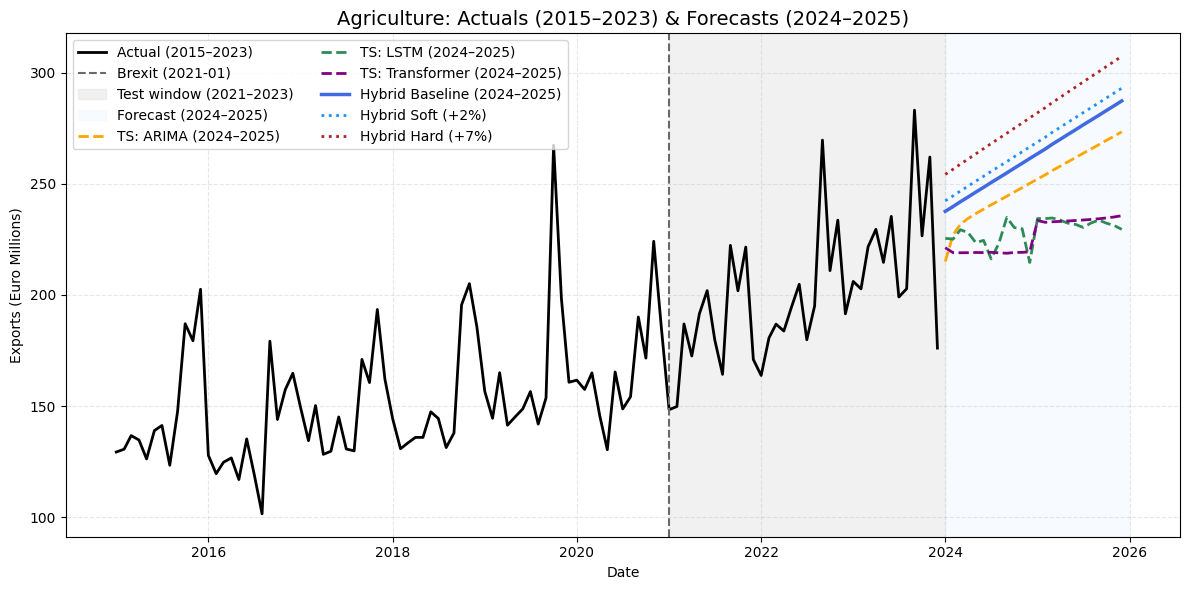

[OK] Saved → combined_forecast_Agriculture.png


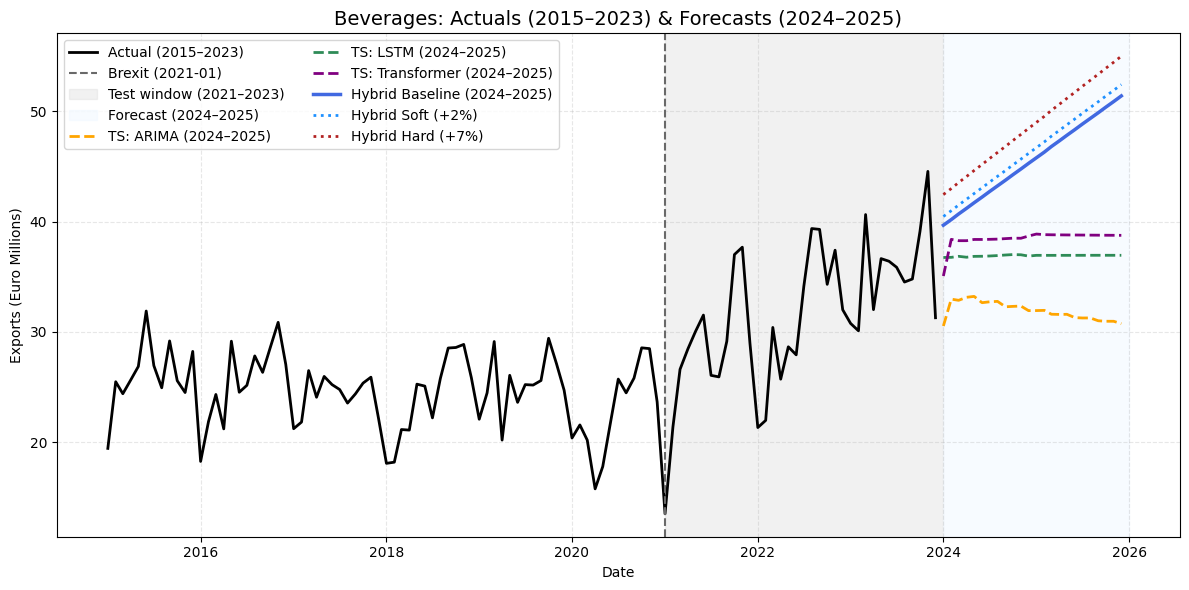

[OK] Saved → combined_forecast_Beverages.png


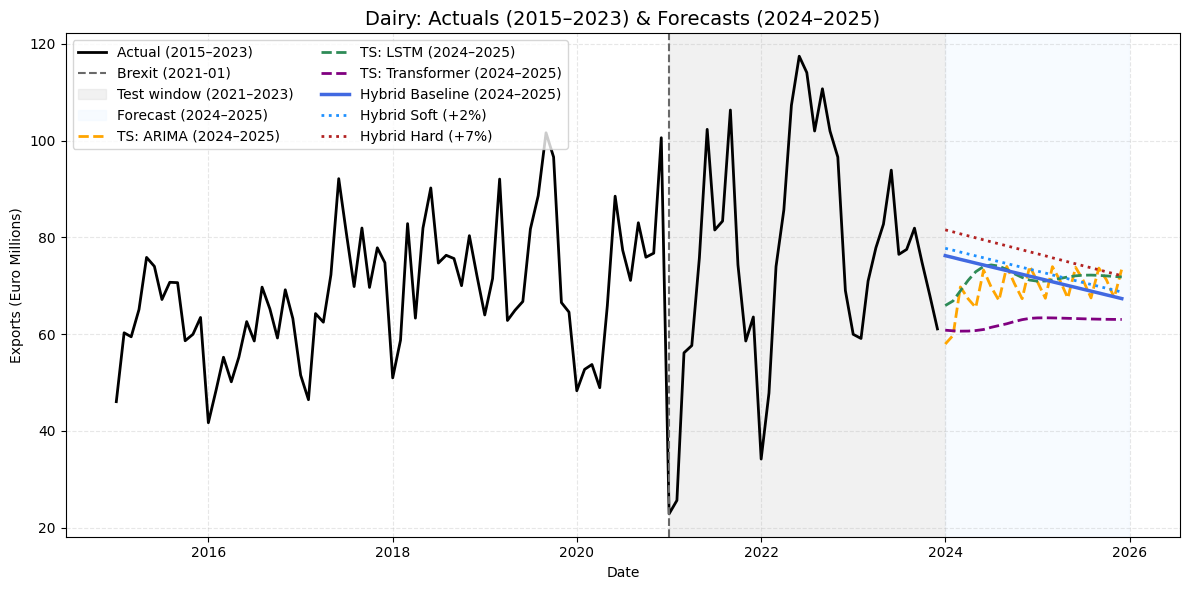

[OK] Saved → combined_forecast_Dairy.png


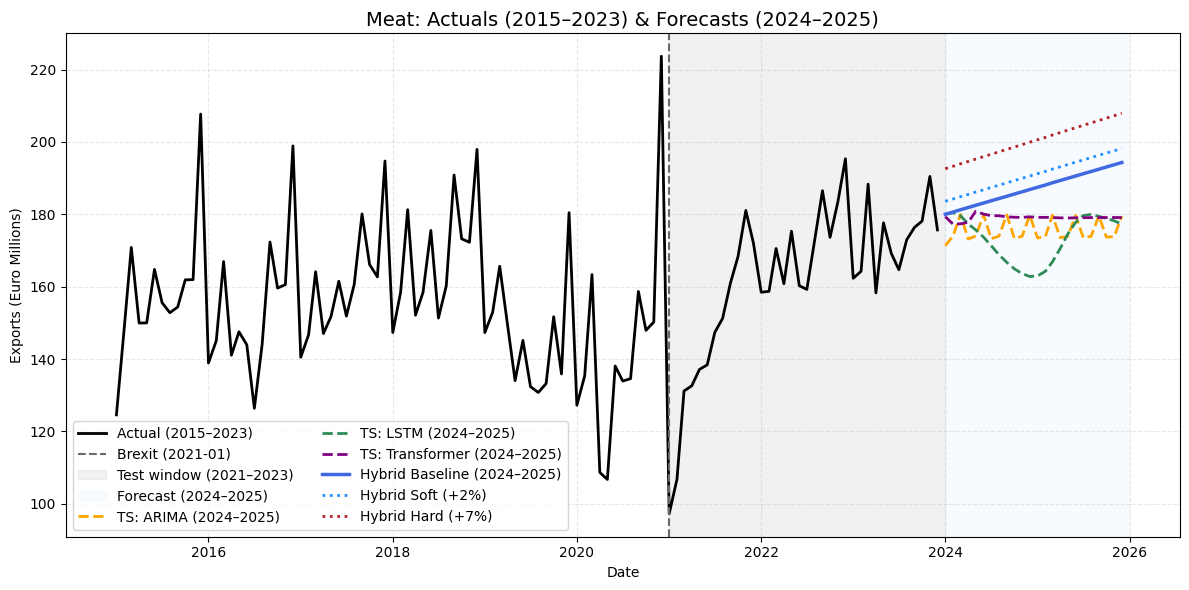

[OK] Saved → combined_forecast_Meat.png


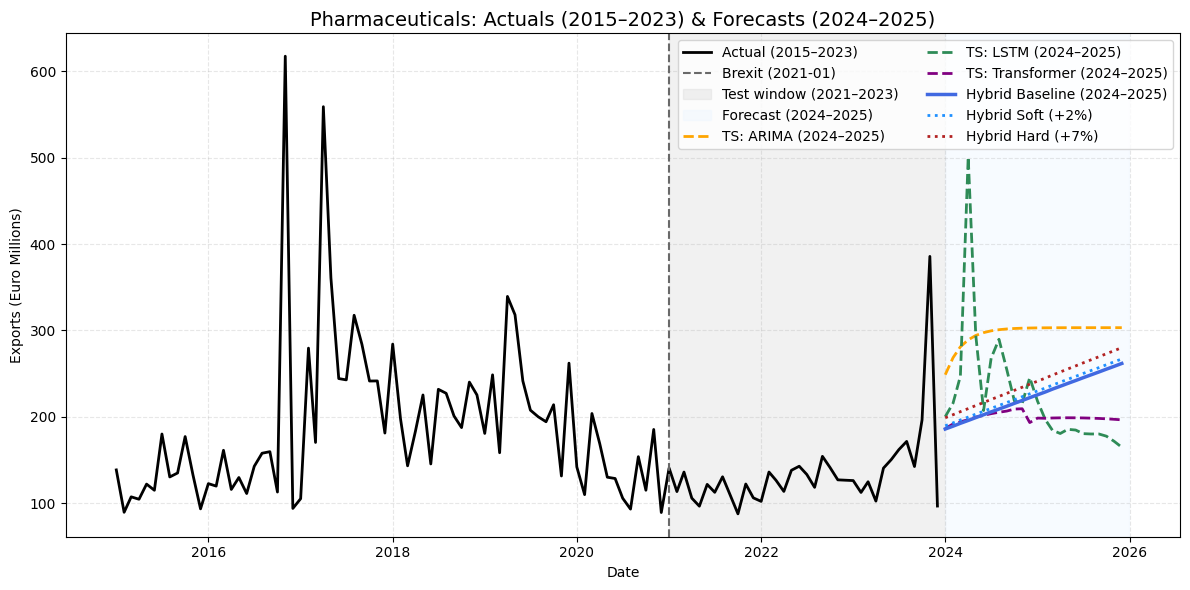

[OK] Saved → combined_forecast_Pharmaceuticals.png


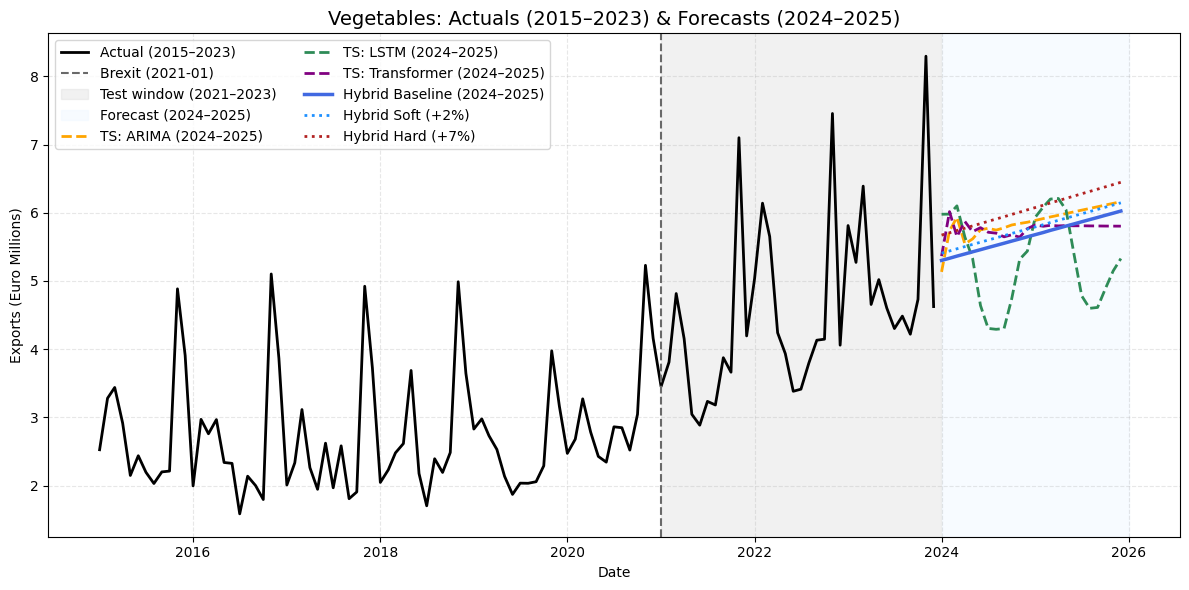

[OK] Saved → combined_forecast_Vegetables.png


In [ ]:
# plot_2015_2025_combined.py
# Combined 2015–2025 plot per sector:
#  - Actuals (2015–2023) from PPML_Hybrid_prediction.xlsx
#  - Time-series forecasts (2024–2025) from Time_series_forecasts_2024_2025.xlsx
#  - Hybrid Baseline + Soft + Hard (2024–2025) from Hybrid_Forecasts_Future.xlsx
#
# Saves: combined_forecast_{sector}.png

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#  FILES
ACTUALS_FILE = Path("/content/PPML_Hybrid_prediction.xlsx")         # sheet: PPML_panel
TS_FILE      = Path("/content/Time_series_forecasts_2024_2025.xlsx") # sheet: Forecasts_Future
HYB_FILE     = Path("/content/Hybrid_Forecasts_Future.xlsx")         # sheets: Baseline_Future, Soft_Brexit_Future, Hard_Brexit_Future

SECTORS = ["Agriculture","Beverages","Dairy","Meat","Pharmaceuticals","Vegetables"]
TEST_START = pd.Timestamp("2021-01-01")
TEST_END   = pd.Timestamp("2023-12-31")
FUT_START  = pd.Timestamp("2024-01-01")
FUT_END    = pd.Timestamp("2025-12-31")

#LOAD DATA
# Actuals
hp = pd.read_excel(ACTUALS_FILE, sheet_name="PPML_panel")
hp.columns = [c.strip() for c in hp.columns]
for c in ["Date","Sector","Actual_Exports"]:
    if c not in hp.columns:
        raise ValueError(f"PPML_panel missing: {c}")
hp["Date"] = pd.to_datetime(hp["Date"], errors="coerce")

# Time-series future (A)
tsf = pd.read_excel(TS_FILE, sheet_name="Forecasts_Future")
tsf.columns = [c.strip() for c in tsf.columns]
for c in ["Date","Sector","Pred_ARIMA","Pred_LSTM","Pred_Transformer"]:
    if c not in tsf.columns:
        raise ValueError(f"Forecasts_Future missing: {c}")
tsf["Date"] = pd.to_datetime(tsf["Date"], errors="coerce")

# Hybrid future (B)
# Baseline
hyb_base = pd.read_excel(HYB_FILE, sheet_name="Baseline_Future")
hyb_base.columns = [c.strip() for c in hyb_base.columns]
hyb_base["Date"] = pd.to_datetime(hyb_base["Date"], errors="coerce")
# Soft
hyb_soft = pd.read_excel(HYB_FILE, sheet_name="Soft_Brexit_Future")
hyb_soft.columns = [c.strip() for c in hyb_soft.columns]
hyb_soft["Date"] = pd.to_datetime(hyb_soft["Date"], errors="coerce")
# Hard
hyb_hard = pd.read_excel(HYB_FILE, sheet_name="Hard_Brexit_Future")
hyb_hard.columns = [c.strip() for c in hyb_hard.columns]
hyb_hard["Date"] = pd.to_datetime(hyb_hard["Date"], errors="coerce")

# Handle possible column naming variants for hybrid future
# Baseline may use "Hybrid_Future" or "Hybrid_Baseline_Future"
base_col = "Hybrid_Future" if "Hybrid_Future" in hyb_base.columns else "Hybrid_Baseline_Future"
if base_col not in hyb_base.columns:
    raise ValueError("Baseline_Future must contain 'Hybrid_Future' or 'Hybrid_Baseline_Future'.")

# Soft may use "Hybrid_Soft_Future"
soft_col = "Hybrid_Soft_Future" if "Hybrid_Soft_Future" in hyb_soft.columns else None
if soft_col is None:
    # Sometimes saved as "Hybrid_Soft"
    if "Hybrid_Soft" in hyb_soft.columns:
        soft_col = "Hybrid_Soft"
    else:
        raise ValueError("Soft_Brexit_Future must contain 'Hybrid_Soft_Future' (or 'Hybrid_Soft').")

# Hard may use "Hybrid_Hard_Future"
hard_col = "Hybrid_Hard_Future" if "Hybrid_Hard_Future" in hyb_hard.columns else None
if hard_col is None:
    # Sometimes saved as "Hybrid_Hard"
    if "Hybrid_Hard" in hyb_hard.columns:
        hard_col = "Hybrid_Hard"
    else:
        raise ValueError("Hard_Brexit_Future must contain 'Hybrid_Hard_Future' (or 'Hybrid_Hard').")


# PLOTTING FUNCTION
def plot_sector(sector: str):
    # Actuals 2015–2023
    a = (hp[hp["Sector"]==sector]
           .sort_values("Date")[["Date","Actual_Exports"]])
    # Time series future 2024–2025
    t = (tsf[tsf["Sector"]==sector]
           .sort_values("Date")[["Date","Pred_ARIMA","Pred_LSTM","Pred_Transformer"]])
    # Hybrid future 2024–2025
    b = (hyb_base[hyb_base["Sector"]==sector]
           .sort_values("Date")[["Date", base_col]]
           .rename(columns={base_col:"Hybrid_Baseline"}))
    s = (hyb_soft[hyb_soft["Sector"]==sector]
           .sort_values("Date")[["Date", soft_col]]
           .rename(columns={soft_col:"Hybrid_Soft"}))
    h = (hyb_hard[hyb_hard["Sector"]==sector]
           .sort_values("Date")[["Date", hard_col]]
           .rename(columns={hard_col:"Hybrid_Hard"}))

    # Figure
    fig, ax = plt.subplots(figsize=(12,6))
    plt.title(f"{sector}: Actuals (2015–2023) & Forecasts (2024–2025)", fontsize=14)

    # Actuals
    ax.plot(a["Date"], a["Actual_Exports"], color="black", lw=2, label="Actual (2015–2023)")

    # Brexit margins
    ax.axvline(pd.Timestamp("2021-01-01"), color="dimgray", lw=1.5, linestyle="--", label="Brexit (2021-01)")
    # Shade test window 2021–2023
    ax.axvspan(TEST_START, TEST_END, color="lightgray", alpha=0.3, label="Test window (2021–2023)")
    # Shade forecast window 2024–2025
    ax.axvspan(FUT_START, FUT_END, color="aliceblue", alpha=0.5, label="Forecast (2024–2025)")

    # Time-series forecasts (2024–2025)
    ax.plot(t["Date"], t["Pred_ARIMA"],        color="orange",  lw=2, linestyle="--", label="TS: ARIMA (2024–2025)")
    ax.plot(t["Date"], t["Pred_LSTM"],         color="seagreen",lw=2, linestyle="--", label="TS: LSTM (2024–2025)")
    ax.plot(t["Date"], t["Pred_Transformer"],  color="purple",  lw=2, linestyle="--", label="TS: Transformer (2024–2025)")

    # Hybrid forecasts (2024–2025)
    ax.plot(b["Date"], b["Hybrid_Baseline"],   color="royalblue", lw=2.5, label="Hybrid Baseline (2024–2025)")
    ax.plot(s["Date"], s["Hybrid_Soft"],       color="dodgerblue", lw=2, linestyle=":", label="Hybrid Soft (+2%)")
    ax.plot(h["Date"], h["Hybrid_Hard"],       color="firebrick",  lw=2, linestyle=":", label="Hybrid Hard (+7%)")

    ax.set_ylabel("Exports (Euro Millions)")
    ax.set_xlabel("Date")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(ncol=2)
    plt.tight_layout()
    # Save PNG
    outname = f"combined_forecast_{sector.replace(' ','_')}.png"
    plt.savefig(outname, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"[OK] Saved → {outname}")

# RUN FOR ALL SECTORS
for sec in SECTORS:
    try:
        plot_sector(sec)
    except Exception as e:
        print(f"[WARN] Plot failed for {sec}: {e}")
